In [2]:
#from helper import IMAGE_RES
IMAGE_RES = 100
import warnings
warnings.filterwarnings('ignore')


In [3]:
import os
import cv2
import time
import json
import keras
import tensorflow
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)

2024-04-03 14:58:33.455967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 14:58:33.456077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 14:58:33.593043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# training

# define the subdirectory where you training data is located
training_sub = "data/train"
testing_sub = "data/test"

training_path = "/kaggle/input/fer2013/train"
validation_path = "/kaggle/input/fer2013/test"




In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,  #normalize pixel values to be between 0 and 1
    #horizontal_flip=True,  #randomly flip images horizontally
    #validation_split=0.3 # set data split
)

target_size = (IMAGE_RES, IMAGE_RES)  
batch_size = 32

In [6]:
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical", 
  
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical", 
   
)

class_names = os.listdir(training_path)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
num_rows = 3  
num_cols = (len(class_names) + num_rows - 1) // num_rows

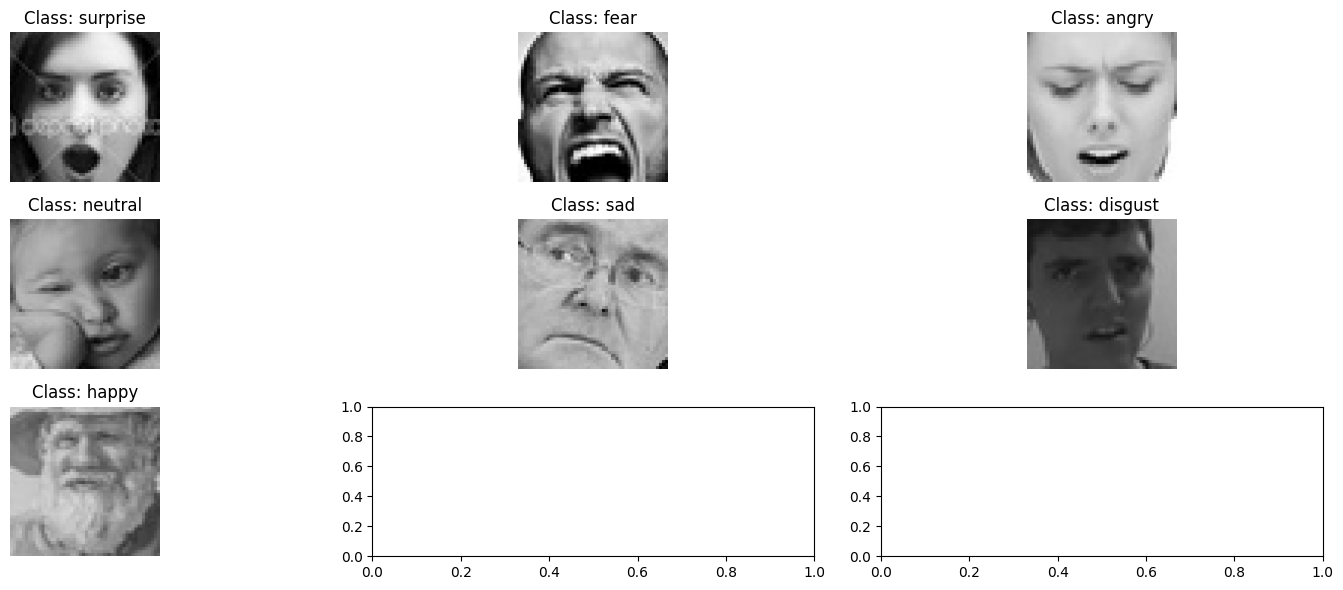

In [8]:
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))


for i, class_name in enumerate(class_names):
    class_path = os.path.join(training_path, class_name)

    image_files = [
        f for f in os.listdir(class_path) if f.endswith(".jpg") or f.endswith(".png")
    ]

    img_path = os.path.join(class_path, image_files[0])
    img = image.load_img(img_path, target_size=target_size)
    axs[i // num_cols, i % num_cols].imshow(img)
    axs[i // num_cols, i % num_cols].set_title(f"Class: {class_name}")
    axs[i // num_cols, i % num_cols].axis("off")


plt.tight_layout()


plt.show()

In [9]:
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
file_name = "data_lookup_train.json"

with open(file_name, "w") as json_file:
    json.dump(class_indices, json_file)


print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_validation_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {class_indices}")

Number of training samples: 28709
Number of validation samples: 7178
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [10]:
#num_classes = len(directory_reverse_lookup.keys())
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_RES, IMAGE_RES, 3))

# Freeze the base model's layers to prevent training them
for layer in base_model.layers:
    layer.trainable = False

    

x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

checkpoint = ModelCheckpoint(
    'best_weights.keras',
    monitor='val_loss',  
    save_best_only=True,
    mode='min',  
    verbose=1
)


#model = models.Sequential([
#    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_RES, IMAGE_RES, 3)),
#    layers.MaxPooling2D((2, 2)),
#    layers.Conv2D(64, (3, 3), activation='relu'),
#    layers.MaxPooling2D((2, 2)),
#    layers.Conv2D(64, (3, 3), activation='relu'),
#    layers.Flatten(),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(num_classes, activation='softmax')
#])



early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1
)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,010,119 (57.26 MB)

 Trainable params: 295,431 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks=[early_stopping, lr_schedule, checkpoint],
)

Epoch 1/50
  3/897 ━━━━━━━━━━━━━━━━━━━━ 1:13 82ms/step - accuracy: 0.1406 - loss: 2.2330 

I0000 00:00:1712156349.657101      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


367/897 ━━━━━━━━━━━━━━━━━━━━ 1:17 146ms/step - accuracy: 0.2440 - loss: 1.9629

W0000 00:00:1712156402.925414     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2749 - loss: 4.7809
Epoch 1: val_loss improved from inf to 1.56478, saving model to best_weights.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 176s 186ms/step - accuracy: 0.2749 - loss: 4.7812 - val_accuracy: 0.4089 - val_loss: 1.5648 - learning_rate: 1.0000e-04
Epoch 2/50
  1/897 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.2812 - loss: 1.7146
Epoch 2: val_loss did not improve from 1.56478
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2812 - loss: 1.7146 - val_accuracy: 0.2000 - val_loss: 1.6145 - learning_rate: 1.0000e-04
Epoch 3/50
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3601 - loss: 17.8403
Epoch 3: val_loss improved from 1.56478 to 1.50946, saving model to best_weights.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.3602 - loss: 17.8240 - val_accuracy: 0.4280 - val_loss: 1.5095 - learning_rate: 1.0000e-04
Epoch 4/50
  1/897 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5000 - loss: 1.6492


In [12]:
# Save the model weights
model.save_weights('model_weights.weights.h5')

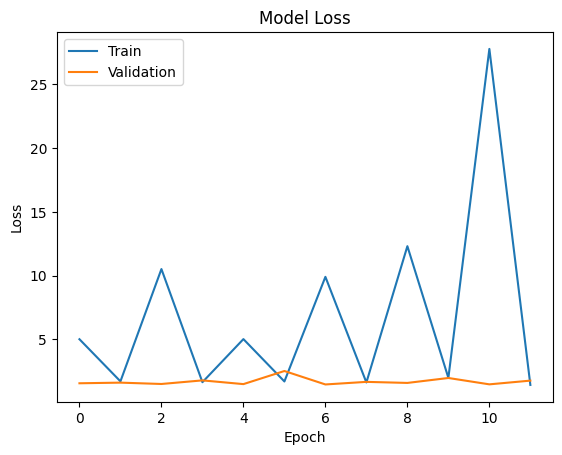

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

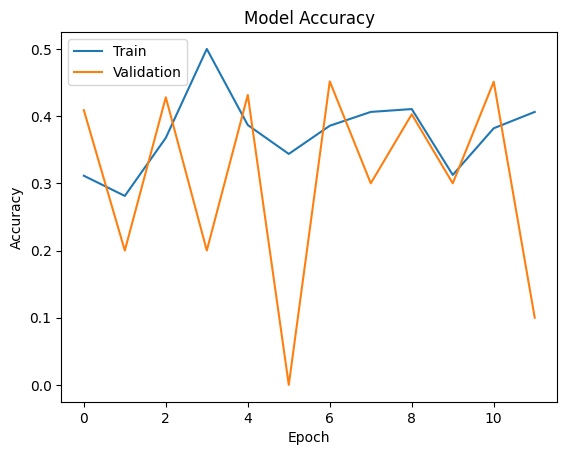

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()